# Imports

This notebook is made to compare and evaluate each "best model" we obtained for DANN, CORAL and Basis model (VGG-16). All models are trained and tuned in their corresponding files (in the Resources folder). This file takes the hyperparameter results, evaluates them, and compares the best models obtained after hyperparameter tuning based on the result of multiple metrics: testing accuracy, f1-score, confusion matrix and average AUPRC.

In [78]:
from torch.utils.data import Dataset
import torch 
import os
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, auc

We can also find the device to use:

In [79]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == "cuda":
    torch.cuda.empty_cache()

This notebook starts by importing the test dataset. We will use the test dataset as a benchmark base for comparing the performance of the best models we obtain after tuning DANN, CORAL, and base models. Again, the performances evaluated here are the testing accuracy, f1-score, confusion matrix and average AUPRC.

In [80]:
# Transform to apply to the minibatches for data augmentation
# Define the transformation to apply
# Transformations: Random horizontal and vertical flips, halving and doubling the brightness
# This should improve the prediction accuracy
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=[0.75, 1.25])], p=0.5)
])

class CustomDataset(Dataset):
    
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.images = os.listdir(root_dir)
        self.labels = torch.load(label_dir).long()

        # Remove the labels that do not belong to this split of the dataset (Labels is all labels)
        self.labels = self.labels[torch.tensor([int(img_name[3:9]) for img_name in self.images])]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        image = transform(image)
        label = self.labels[idx] # Since we removed the labels that do not belong to this split, we can use idx directly
        return image, label
    
# Extract the generated data test set
generated_data_root = "./Data Generation/Pre Processed Data Generated"
test_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Testing/", generated_data_root + "/Square Images/y_generated.pt")

# Extract the real data  test set
real_data_root = "./Real life data/Pre processed Real Life"
test_real_dataset = CustomDataset(real_data_root + "/Square Images/Testing/", real_data_root + "/Square Images/y_real_life.pt")

Finally, because we are using balanced accuracy scores, we can use the class analytics gathered during pre-processing to define the following class distribution array:

In [81]:
class_proportions_gen = np.array([0.3198, 0.1602, 0.0405, 0.0400, 0.0406, 0.0201, 0.0404, 0.1596, 0.0392, 0.0397, 0.0400, 0.0196, 0.0404])
class_proportions_real = np.array([0.3228, 0.1738, 0.0347, 0.0415, 0.0454, 0.0206, 0.0354, 0.1490, 0.0284, 0.0463, 0.0432, 0.0234, 0.0354])

# Print the sum of the class proportions as a sanity check
print(class_proportions_gen.sum())
print(class_proportions_real.sum())

1.0001
0.9998999999999999


 We can now proceed to defining a function that creates a data loader for both datasets, oversampling the minority classes and applying horizontal flip and blur transformations:

In [82]:
def get_gen_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_gen, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

def get_real_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_real, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# Model Loading

We now define the classes for each model. The base model and CORAL model have one class, while the DANN has four classes: one for the feature extractor, one for the discriminator, one for the classifier and one for the gradient reversal.

In [83]:
# Define the class for the Base Model
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [84]:
# Define the four classes for the DANN
class GradientReversal(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, lamb):
        ctx.lamb = lamb # Save the lambda DA hyperparameter to use during the backward pass
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lamb
        return output, None

class Discriminator(nn.Module):

    def __init__(self, input_size=4608, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, h, lamb):
        h = GradientReversal.apply(h, lamb)
        y = self.layer(h)
        return y
    
class Classifier(nn.Module):

    def __init__(self, input_size=4608, num_classes=13):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, h):
        c = self.layer(h)
        return c
    
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        # Import the VGG16 model
        self.conv = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features

        # Freeze all the weights in modules 0 up-to and including 25
        for param in self.conv[:25].parameters():
            param.requires_grad = False

        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return x

In [85]:
class CoralModel(nn.Module):

    def __init__(self, num_classes=13):
        
        super(CoralModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes)
        )

        # Freeze all the weights in modules 0 up-to and including 25
        for param in self.features[:25].parameters():
            param.requires_grad = False


    def forward(self, x):
        h = self.features(x)
        h = torch.flatten(h, 1)
        output = self.classifier(h)
        return h, output

We now load the models we saved as the best ones for each model type (DANN, CORAL, and Base Model).

In [86]:
DANN_path = "./Resources/DANN/"
BASE_path = "./Resources/BASE/best_model.ckpt"
CORAL_path = "./Resources/CORAL/best_model.ckpt"

# Instantiate the model object for the base model
base_model = BaseModel()
# Load the state dictionary from the checkpoint file
state_dict = torch.load(BASE_path, map_location=torch.device(DEVICE))
# Load the state dictionary into the model
base_model.load_state_dict(state_dict)
# Put the model into evaluation mode
base_model.eval()

# Instantiate the classifier model object for the dann model
DANN_C = Classifier()
# Load the state dictionary from the checkpoint file
state_dict = torch.load(DANN_path+"best_model_C.ckpt", map_location=torch.device(DEVICE))
# Load the state dictionary into the model
DANN_C.load_state_dict(state_dict)
# Put the model into evaluation mode
DANN_C.eval()

# Instantiate the feature extractor model object for the dann model
DANN_F = FeatureExtractor()
# Load the state dictionary from the checkpoint file
state_dict = torch.load(DANN_path+"best_model_F.ckpt", map_location=torch.device(DEVICE))
# Load the state dictionary into the model
DANN_F.load_state_dict(state_dict)
# Put the model into evaluation mode
DANN_F.eval()

# Instantiate the discriminator model object for the dann model
DANN_D = Discriminator()
# Load the state dictionary from the checkpoint file
state_dict = torch.load(DANN_path+"best_model_D.ckpt", map_location=torch.device(DEVICE))
# Load the state dictionary into the model
DANN_D.load_state_dict(state_dict)
# Put the model into evaluation mode
DANN_D.eval()

# Instantiate the model object for the coral model
coral_model = CoralModel()
# Load the state dictionary from the checkpoint file
state_dict = torch.load(CORAL_path, map_location=torch.device(DEVICE))
# Load the state dictionary into the model
coral_model.load_state_dict(state_dict)
# Put the model into evaluation mode
coral_model.eval()

# TO not show the CORAL architecture after coral_model.eval()
print("")

# Hyperparameter Tuning Results

We will load the hyperparameter tuning results obtained for each model (DANN, CORAL, Base model) and plot them separately in a table.

In [87]:
def plot_HP_results(dataframe, model):

    # find the index of the maximum value in column 'Final validation accuracy' to make line bold in table
    max_index = dataframe['Final validation accuracy'].idxmax() + 1

    # Multiply accuracy column by 100 to get percentage results and Set the maximum number of significant numbers to 2
    dataframe['Final validation accuracy'] = (dataframe['Final validation accuracy'].multiply(100, axis=0).round(2)).astype(str)+'%'
   

    # Set font options
    font = {'family': 'serif', 'weight': 'normal', 'size': 14}

    if model == "CORAL model":
        # Set table properties
        fig, ax = plt.subplots(figsize=(15, 6), dpi=300)
        ax.axis('off')
    else:
        # Set table properties
        fig, ax = plt.subplots(figsize=(15, 4), dpi=300)
        ax.axis('off')


    table = tb = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, cellLoc='center', 
                loc='center', fontsize=14, colColours = plt.cm.BuPu(np.full(11, 0.1)))

    # Set cell font properties
    for i in range(len(dataframe.columns)):
        table[0, i].set_text_props(fontproperties=font)
        for j in range(len(dataframe)):
            table[j + 1, i].set_text_props(fontproperties=font)
            if j + 1 == max_index:
                table[j + 1, i].set_text_props(fontproperties=FontProperties(weight='bold'))
    tb.set_fontsize(14)
    tb.scale(2, 2)
    fig.tight_layout()

    text = ""

      # Include a subtitle showing all the fixed parameters we trained the model with:
    if model == "DANN model":
        text = "Other parameters are: Gamma(DA)=10; Alpha=10; Beta=0.75; Batch Size=100; Number of epochs=30; Gamma(Focal Loss)=2"
    elif model == "Base model":
        text= "Other parameters are: Number of epochs=1; Learning rate=0.001"
    elif model == "CORAL model":
        text = "Other parameters are: Batch Size=200; Number of epochs=20; Gamma(Focal Loss)=2"

    plt.suptitle("Table showing the results of hyperparameter tuning for the "+model+".\n"+text, fontsize = 14)
    # adjust padding for title
    fig.subplots_adjust(top=0.85)

    
    # Save figure
    plt.savefig("./Results/HyperParameter Tuning Table Results/"+model+".png")
    plt.show()

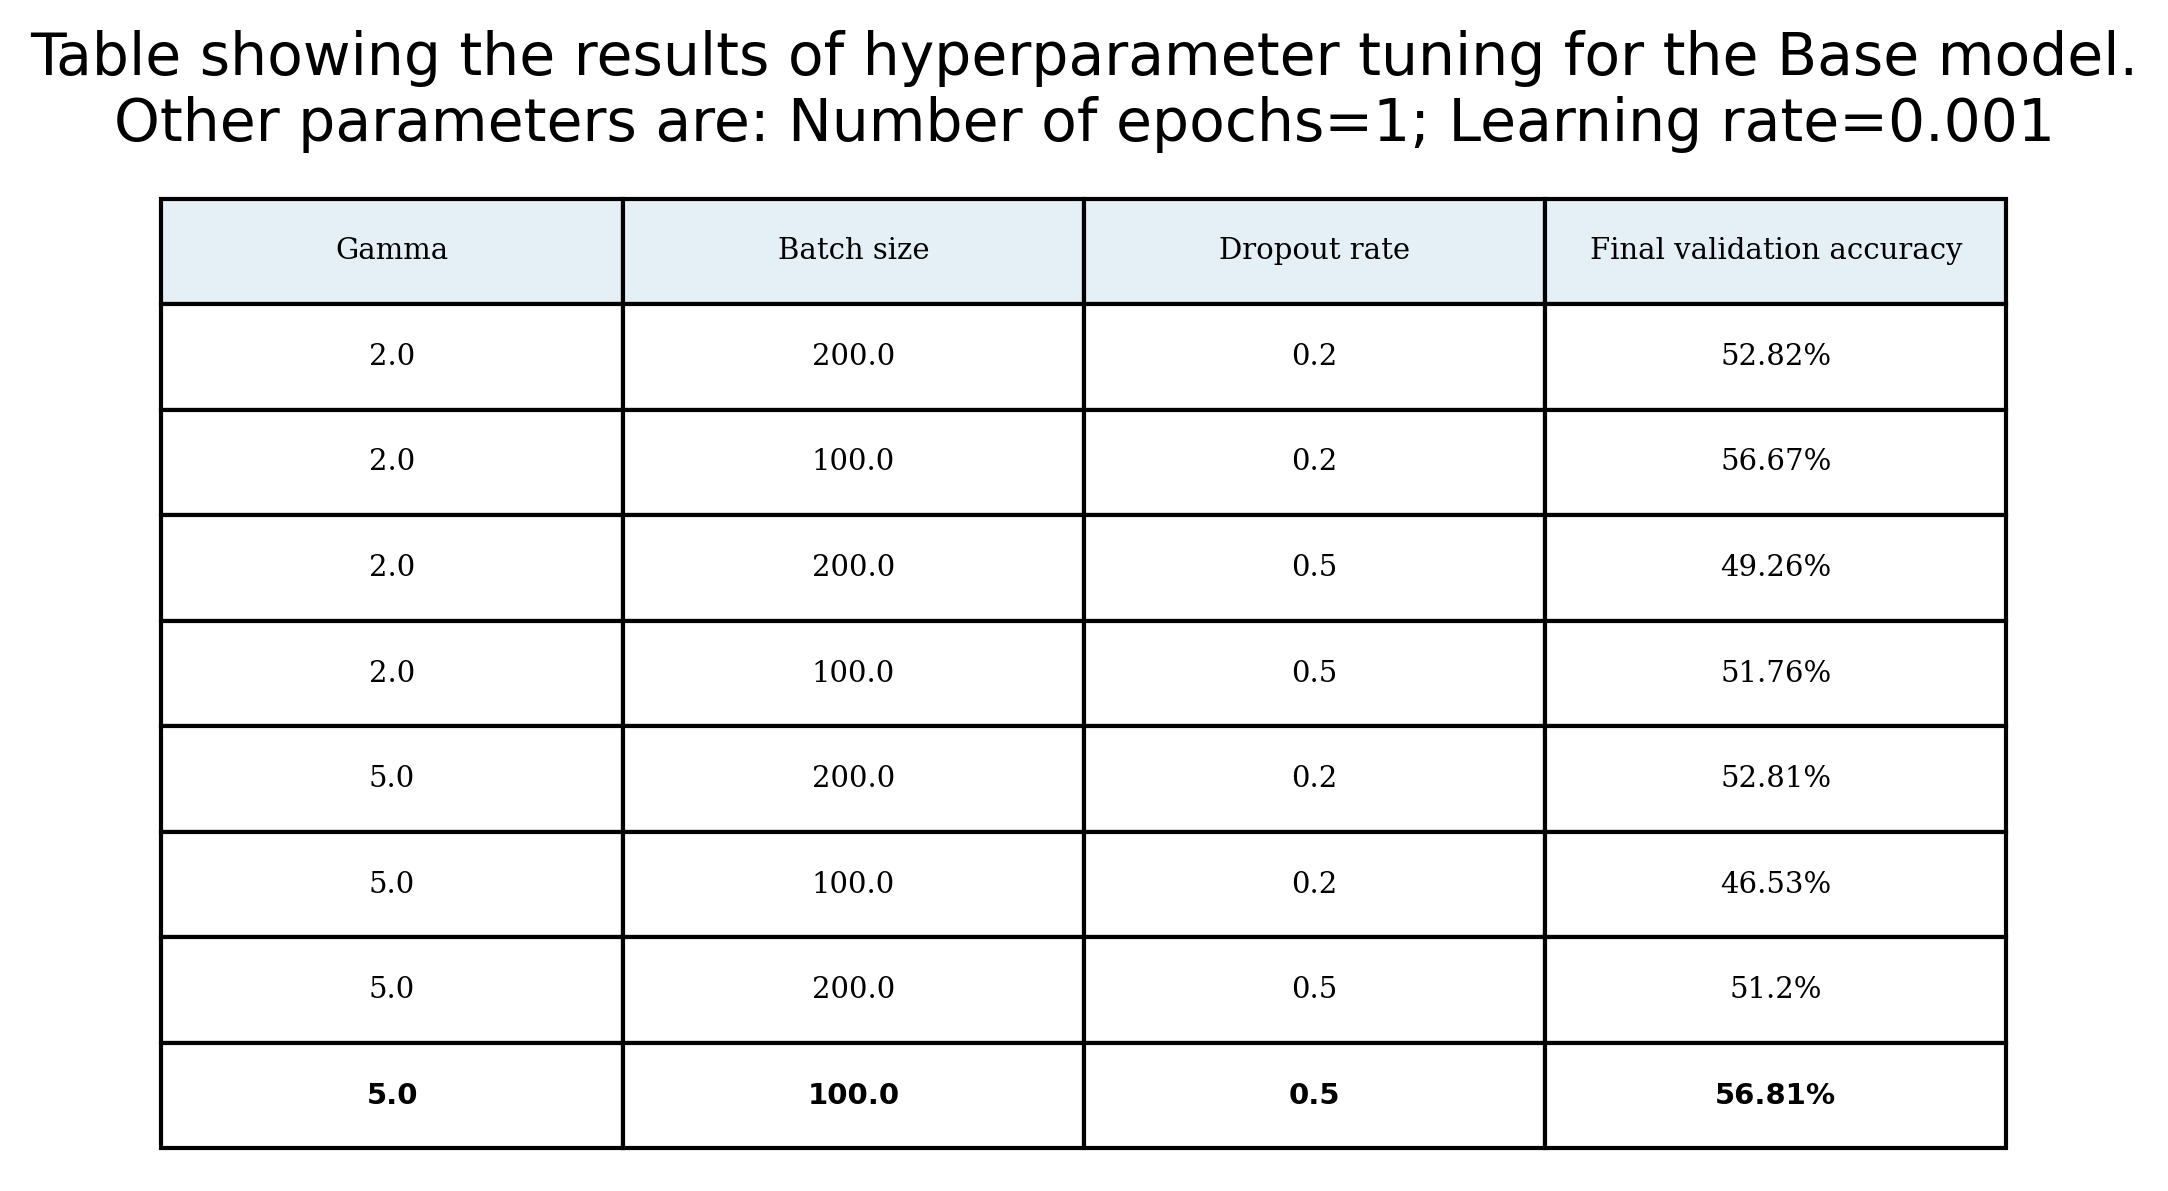

In [88]:
# Load CSV file for the Base model 
BASE_HP_results = pd.read_csv('./Resources/BASE/HP_final_accuracies.csv')

plot_HP_results(BASE_HP_results, "Base model")


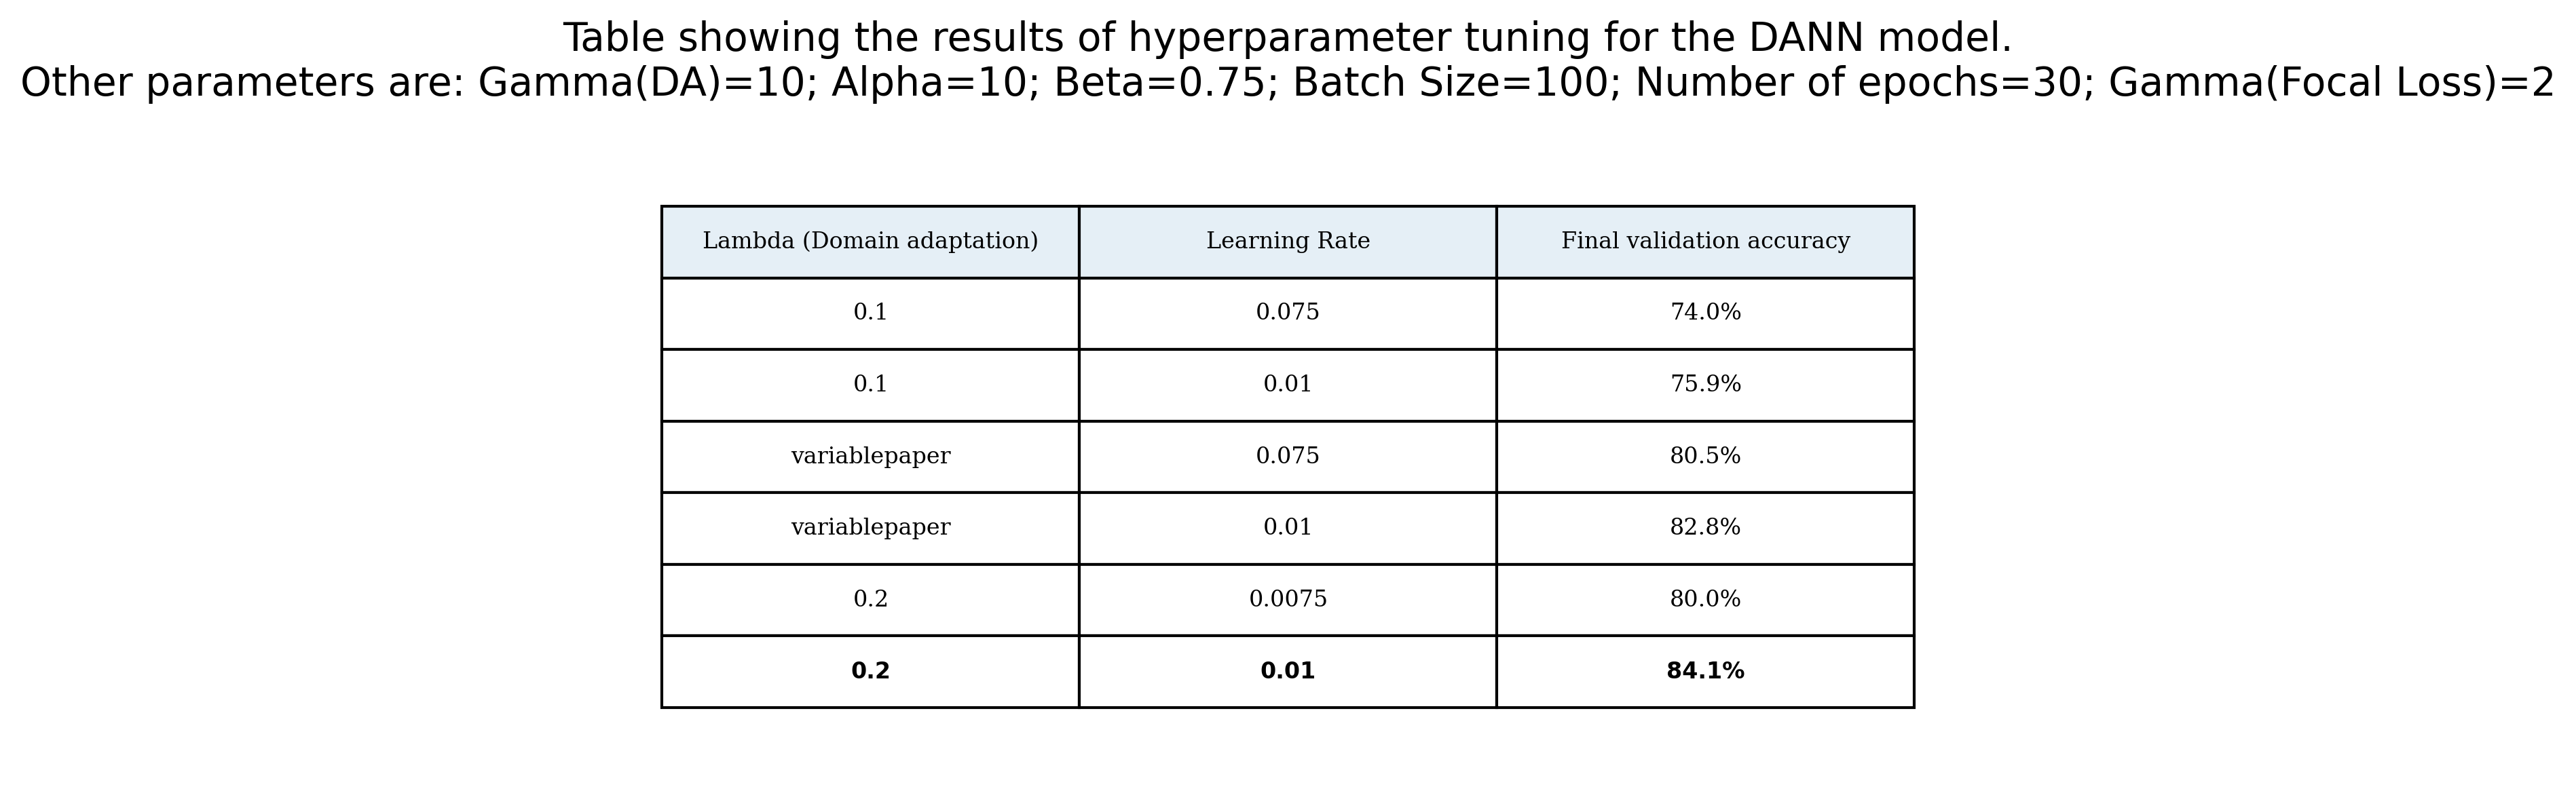

In [89]:
# Load CSV file for the DANN
DANN_HP_results = pd.read_csv('./Resources/DANN/HP_final_accuracies.csv')

plot_HP_results(DANN_HP_results, "DANN model")


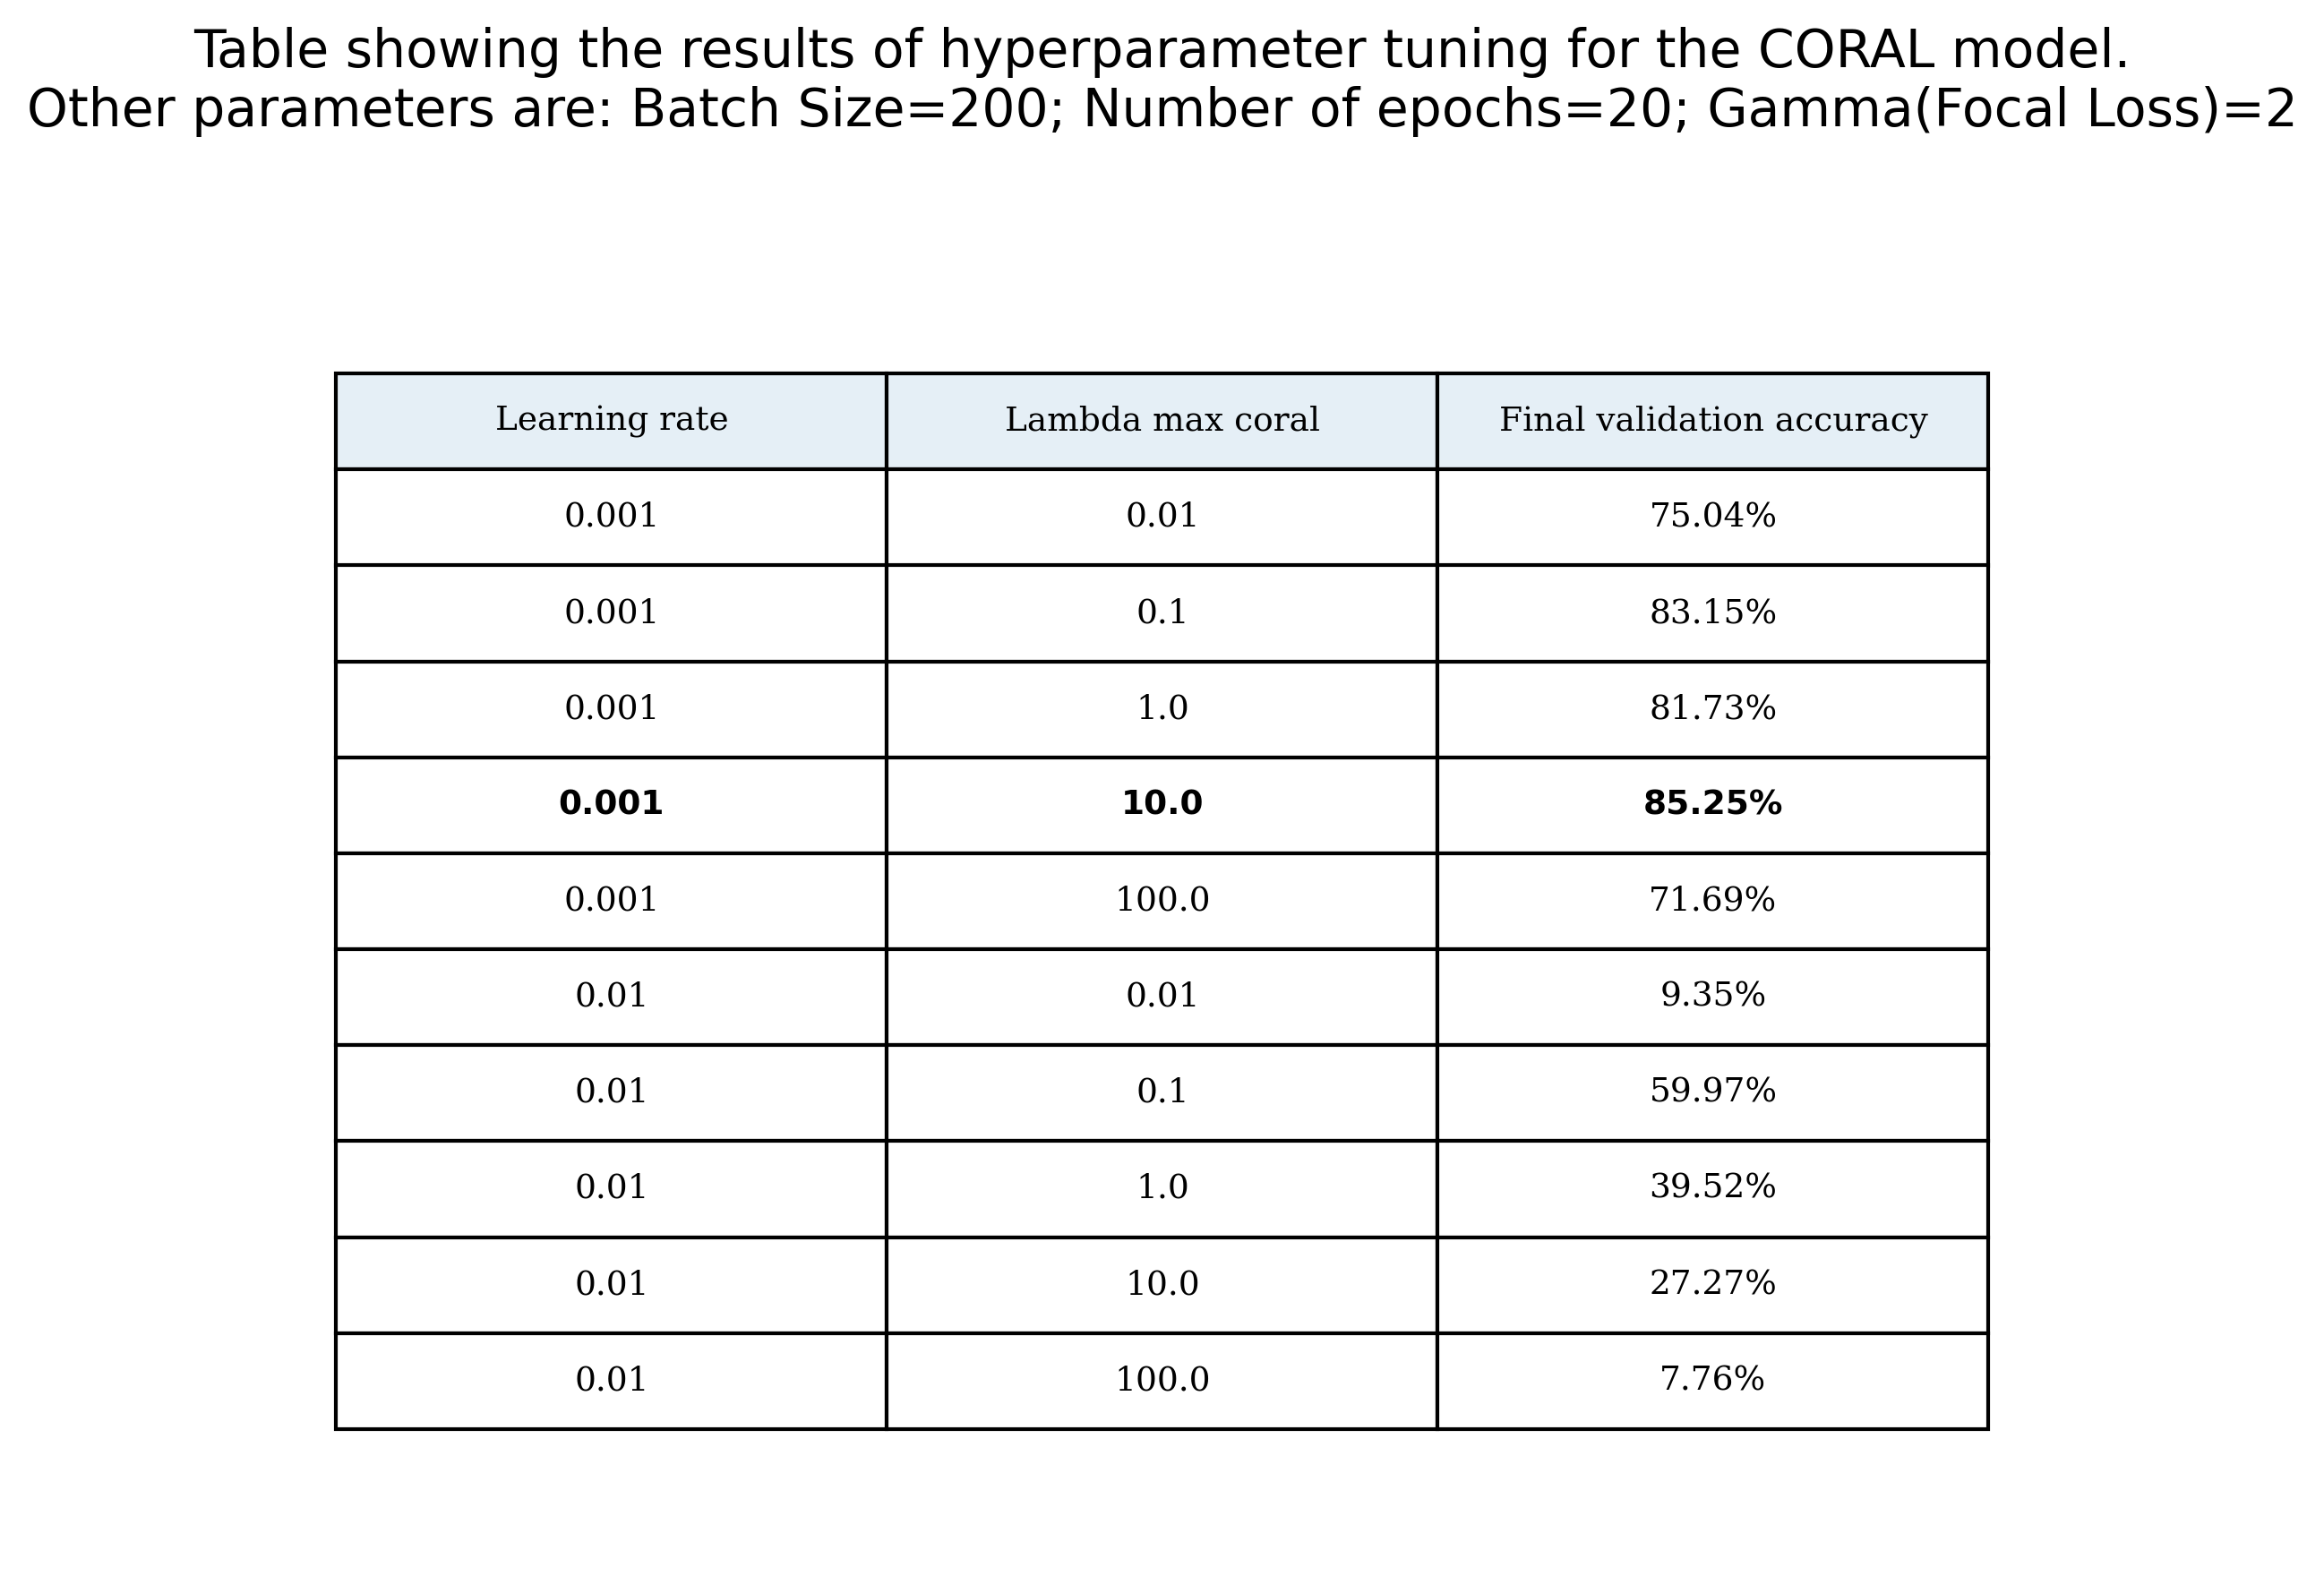

In [90]:
# Load CSV file for the DANN
CORAL_HP_results = pd.read_csv('./Resources/CORAL/HP_final_accuracies.csv')

plot_HP_results(CORAL_HP_results, "CORAL model")

# Metric comparison

### Plotting and metric collection functions

We will compare the performance of the best models using the testing accuracy, f1-score and confusion matrix metrics. 

* Specifically, for the testing accuracy, we will use the balanced accuracy score, which is similar to regular classification accuracy, but it takes into account the frequency of each class. The balanced accuracy score will be computed using on both the real-life dataset and the generated dataset, however, our ultimate goal is to predict labels for real-life images.

* As a reminder, the f1-score is a performance metric that provides a balance between the precision and recall of the model. The f1-score ranges from 0 to 1, with a higher score indicating a better performance of the model. The equation for f1-score is: $$ f1 = \frac{2 (precision * recall)}{precision + recall}$$ where $precision$ is the number of true positives (correctly predicted positive samples) divided by the total number of predicted positive samples, and $recall$ is the number of true positives divided by the total number of actual positive samples. In other words, f1-score takes into account both the model's ability to correctly identify positive samples (recall) and its tendency to not mislabel negative samples as positive (precision). 

* The confusion matrix compares the predicted class labels with the true class labels and counts the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each class. It can help identify which classes the model is having difficulty classifying correctly, and whihc classes it can predict with ease.

* Finally, the AUPRC measures the overall quality of the model's predictions, taking into account both precision and recall across all possible classification thresholds. A high average AUPRC indicates that the model has a good balance of precision and recall across all possible classification thresholds, and is able to accurately distinguish between positive and negative cases. Conversely, a low average AUPRC indicates poor performance, and suggests that the model is making many incorrect predictions or missing many true positive cases.








We first define the balanced accuracy function as follows:

In [91]:
# Define the balanced accuracy function
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

To compare the final testing accuracies of each model (DANN, CORAL, and Base model), we evaluate their performance on both the real-life dataset and the generated dataset. Additionally, we analyze the metrics with and without oversampling. For this purpose, we use a function that takes the model(s), batch size, dataset and oversampling boolean as input to compute the testing accuracy, f1-score, confusion matrix and average AUPRC. 

It's important to note that the most significant metrics are the one on the real-life dataset with oversampling. The ultimate objective of the model is to make predictions on real-life chess pieces, and we intend to provide significance to the metric functions by equalizing the class weights (via oversampling).

In [92]:
# Define the testing accuracy evaluation function
def evaluate(model, batch_size, dataset, model2=None, oversampling=True, coral=False):
    # Chekc if oversampling must be done
    if oversampling:
        # Define the data loaders accounting for the batch size
        # Check which data to laod (real life or generated)
        if dataset == "real life":
            loader = get_real_loader(test_real_dataset, batch_size=batch_size)
        elif dataset == "generated":
            loader = get_gen_loader(test_gen_dataset, batch_size=batch_size)
    else:
        if dataset == "real life":
            loader = DataLoader(test_real_dataset, batch_size=batch_size)
        elif dataset == "generated":
            loader = DataLoader(test_gen_dataset, batch_size=batch_size)

    # Makes sur emodel is in evaluation mode
    model.eval()

    # Set accumulated accuracy to 0
    acc = 0

    y_true = [] # Ground truth labels
    y_hat = [] # Predicted labels

    # Remove grad
    with torch.no_grad():
        for images, labels in loader:
            # Move the data to the device
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            if coral:
                # Forward pass
                _, y_pred_prob = model(images).to(DEVICE)
            else:
                # Forward pass
                y_pred_prob = model(images).to(DEVICE)

            # If there is a second model (for DANN we first gothrough the Feature extractor and then the Classifier)
            if model2:
                y_pred_prob = model2(y_pred_prob).to(DEVICE)

            y_pred = torch.argmax(y_pred_prob, dim=1)

            # Compute the metrics
            acc +=  accuracy(y_pred, labels)

            y_true.extend(labels.numpy())
            y_hat.extend(y_pred.numpy())

        # Compute the average accuracy
        final_accuracy = acc / len(loader)
        
        # Compute the f1 score
        f1 = f1_score(y_true, y_hat, average='weighted')

        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_hat, normalize='true')

        y_true = np.asarray(y_true)
        y_hat = np.asarray(y_hat)

        n_classes = 13
        from sklearn.preprocessing import LabelBinarizer
        lb = LabelBinarizer()
        y_true_binary = lb.fit_transform(y_true)
        y_hat_binary = lb.fit_transform(y_hat)

        precision = dict()
        recall = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_hat_binary[:, i])
            
        auprc = dict()
        for i in range(n_classes):
            auprc[i] = auc(recall[i], precision[i])

        average_auprc = np.mean(list(auprc.values()))

    # Return all metrics computed
    return final_accuracy, f1, cm, average_auprc


To showcase the variations in testing accuracies among the four models, we will create four tables. Each table will display the accuracies of all four models. However, the first table will focus on the real-life dataset with oversampling, the second table will be based on the real-life dataset without oversampling, the third table will feature the generated dataset without oversampling, and the last table will present the accuracies of the generated dataset with oversampling. Again as mentionned above, the third table showing the real-life data with oversampling accuracies is the most significant one.

We will apply the same procedure for the f1-score metric by generating four tables: one showing the f1-scores of all models on the real-life data with oversampling, another without oversampling, and two additional tables for the generated data with and without oversampling.

To plot these tables, we define the "tabulate_results" function, which takes as input the results to display, the dataset from which it was computed ("reallife" or "generated"), and whether oversampling was used (True or False). Additionally, we can specify the metric to show by passing "-acc" or "-f1" as an argument.

In [93]:
'''
Function to plot the given results in a table format.
'''
def tabulate_results (results, dataset, oversampling, metric):
    # Define the title of the plot depending on the dataset evaluated on, the metric eveluated and if we used oversampling
    if metric == "-acc":
        if oversampling:
            title = "Test Accuracy on " + dataset + " with oversampling."
        else:
            title = "Test Accuracy on " + dataset + " without oversampling."
        array = np.array([["Model", "Test Accuracy"], ["DANN", "0"], ["CORAL", "0"], ["Base Model", "0"]])
        array[1:, 1] = np.char.add(np.char.mod('%.2f', results * 100), '%')

    elif metric == "-f1":
        if oversampling:
            title = "F1 Score on " + dataset + " with oversampling."
        else:
            title = "F1 Score on " + dataset + " without oversampling."
        array = np.array([["Model", "F1 Score"], ["DANN", "0"], ["CORAL", "0"], ["Base Model", "0"]])
        array[1:, 1] = results
        
    elif metric == "-auprc":
        if oversampling:
            title = "Average AUPRC on " + dataset + " with oversampling."
        else:
            title = "Average AUPRC on " + dataset + " without oversampling."
        array = np.array([["Model", "Average AUPRC"], ["DANN", "0"], ["CORAL", "0"], ["Base Model", "0"]])
        array[1:, 1] = results

    # Set font options
    font = {'family': 'serif', 'weight': 'normal', 'size': 14}

    # Set table properties
    fig, ax = plt.subplots(figsize=(25, 3), dpi=300)
    ax.axis('off')

    table = ax.table(cellText=array[1:, :], colLabels=array[0,:], cellLoc='center', 
                loc='center', fontsize=14, colColours = plt.cm.BuPu(np.full(11, 0.1)))

    # Set cell font properties
    for i in range(len(array[0,:])):
        table[0, i].set_text_props(fontproperties=font)
        for j in range(len(array[:,0])-1):
            table[j + 1, i].set_text_props(fontproperties=font)
            # if j + 1 == max_index:
            #     table[j + 1, i].set_text_props(fontproperties=FontProperties(weight='bold'))

    table.set_fontsize(14)
    table.scale(2, 2)
    fig.tight_layout()
    plt.title(title)

    if metric == '-acc':
        if oversampling:
            if dataset == "real life":
                # Save figure
                plt.savefig("./Results/Testing Accuracies/Real Life/test_accuracy_real_life_oversample.png")
            else:
                # Save figure
                plt.savefig("./Results/Testing Accuracies/Generated/test_accuracy_generated_oversample.png")
        else:
            if dataset == "real life":
                # Save figure
                plt.savefig("./Results/Testing Accuracies/Real Life/test_accuracy_real_life_no_oversample.png")
            else:
                # Save figure
                plt.savefig("./Results/Testing Accuracies/Generated/test_accuracy_generated_no_oversample.png")
    elif metric == "-f1":
        if oversampling:
            if dataset == "real life":
                # Save figure
                plt.savefig("./Results/F1-Scores/Real Life/f1_real_life_oversample.png")
            else:
                # Save figure
                plt.savefig("./Results/F1-Scores/Generated/f1_generated_oversample.png")
        else:
            if dataset == "real life":
                # Save figure
                plt.savefig("./Results/F1-Scores/Real Life/f1_real_life_no_oversample.png")
            else:
                # Save figure
                plt.savefig("./Results/F1-Scores/Generated/f1_generated_no_oversample.png")

    elif metric == "-auprc":
        if oversampling:
            if dataset == "real life":
                # Save figure
                plt.savefig("./Results/Average AUPRCs/Real Life/auprc_real_life_oversample.png")
            else:
                # Save figure
                plt.savefig("./Results/Average AUPRCs/Generated/auprc_generated_oversample.png")
        else:
            if dataset == "real life":
                # Save figure
                plt.savefig("./Results/Average AUPRCs/Real Life/auprc_real_life_no_oversample.png")
            else:
                # Save figure
                plt.savefig("./Results/Average AUPRCs/Generated/auprc_generated_no_oversample.png")
        
    plt.show()


We also specify a function to plot the confusion matrices obtained. This function takes as input the matrix to plot, the model and dataset it corresponds to and if the data was oversampled or not.

In [94]:
'''
Function to plot the confusion matrices as heatmaps
'''
def plot_confusion_matrix(confusion_matrix, model, dataset, oversampling):
    # Define class names
    class_names = ['Empty Square', 'White Pawn', 'White Knight', 'White Bishop', 'White Rook', 'White Queen', 'White King', 
                'Black Pawn', 'Black Knight', 'Black Bishop', 'Black Rook', 'Black Queen', 'Black King']
    
    # Define figure and axis size
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create heatmap
    heatmap = ax.imshow(confusion_matrix, cmap='Greens')

    # Add colorbar
    cbar = ax.figure.colorbar(heatmap, ax=ax)

    # Set tick labels for x and y axis
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=10)
    ax.set_yticklabels(class_names, fontsize=10)

    # Rotate tick labels and set alignmentto have them appear vertically
    ax.set_xticklabels(class_names, fontsize=10, rotation=90, ha='center')
    plt.setp(ax.get_yticklabels(), rotation=0, ha='right')

    #Loop over data dimensions and create text annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, '{:.1f}'.format(confusion_matrix[i, j]*100),
                        ha="center", va="center", color="black", fontsize=8)

    #Set title and axis labels
    if oversampling:
        title = "Confusion Matrix on " + dataset + " with oversampling (in %) - "+model
    else:
        title = "Confusion Matrix on " + dataset + " without oversampling (in %) - "+model
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted label", fontsize=10)
    ax.set_ylabel("True label", fontsize=10)

    
    if oversampling:
        if dataset == "real life":
            # Save figure
            plt.savefig("./Results/Confusion Matrices/Real Life/"+model+"matrix_real_life_oversample.png")
        else:
            # Save figure
            plt.savefig("./Results/Confusion Matrices/Generated/"+model+"matrix_generated_oversample.png")
    else:
        if dataset == "real life":
            # Save figure
            plt.savefig("./Results/Confusion Matrices/Real Life/"+model+"matrix_real_life_no_oversample.png")
        else:
            # Save figure
            plt.savefig("./Results/Confusion Matrices/Generated/"+model+"matrix_generated_no_oversample.png")

    #Show figure
    plt.show()

We define a last function "get_metrics" to obtain all the metrics we defined above for all models depending on the dataset and if the data is oversampled or not.

In [95]:
# Fix the batch size to 32 for all accuracy computations.
batch_size = 32

In [96]:
'''
Function to get the testing accuracy, f1 score and confusion matrix for all DANN, CORAL and Base models.
It takes as input:
- the dataset to evaluate the metrics on ("real life" or "generated")
- if oversampling must be performed
'''
def get_metrics(dataset, oversampling):
    # Create empty numpy arrays to store the results in
    accuracies = np.empty([0])
    f1s = np.empty([0])
    confusion_matrices = np.empty([0])
    auprcs = np.empty([0])
    
    # Evaluate the DANN model
    accuracy, f1, conf, auprc= evaluate(DANN_F, batch_size, dataset, DANN_C, oversampling=oversampling)
    # Append results
    accuracies = np.append(accuracies, accuracy)
    f1s = np.append(f1s, f1)
    confusion_matrices = np.append(confusion_matrices, conf)
    auprcs = np.append(auprcs, auprc)


    # Evaluate the CORAL model
    accuracy, f1, conf, auprc= evaluate(coral_model, batch_size, dataset, oversampling=oversampling, coral=True)
    # Append results
    accuracies = np.append(accuracies, accuracy)
    f1s = np.append(f1s, f1)
    confusion_matrices = np.append(confusion_matrices, conf)
    auprcs = np.append(auprcs, auprc)

    # Evaluate the Base model
    accuracy, f1, conf, auprc = evaluate(base_model, batch_size, dataset, oversampling=oversampling)
    # Append results
    accuracies = np.append(accuracies, accuracy)
    f1s = np.append(f1s, f1)
    confusion_matrices = np.append(confusion_matrices, conf)
    auprcs = np.append(auprcs, auprc)

    return accuracies, f1s, confusion_matrices.reshape(3, 13, 13), auprcs

### Metric computation

This section focuses on computing the metrics we will plot in the following sections of this notebook.

In [97]:
# First evaluate the accuracies on the real life dataset with oversampling.
accuracies_real_life_oversample, f1s_real_life_oversample, confusion_matrices_real_life_oversample, auprcs_real_life_oversample = get_metrics("real life", True)

KeyboardInterrupt: 

In [ ]:
# Second evaluate the accuracies on the real life dataset without oversampling.
accuracies_real_life_no_oversample, f1s_real_life_no_oversample, confusion_matrices_real_life_no_oversample, auprcs_real_life_no_oversample = get_metrics("real life", False)

In [ ]:
# Third evaluate the accuracies on the generated dataset with oversampling.
accuracies_generated_oversample, f1s_generated_oversample, confusion_matrices_generated_oversample, auprcs_generated_oversample = get_metrics("generated", True)

KeyboardInterrupt: 

In [ ]:
# FOurth evaluate the accuracies on the generated dataset without oversampling.
accuracies_generated_no_oversample, f1s_generated_no_oversample, confusion_matrices_generated_no_oversample, auprcs_generated_no_oversample = get_metrics("generated", False)

### Testing accuracy 

This section plots and analyze the testing accuracies obtained from the previous section.

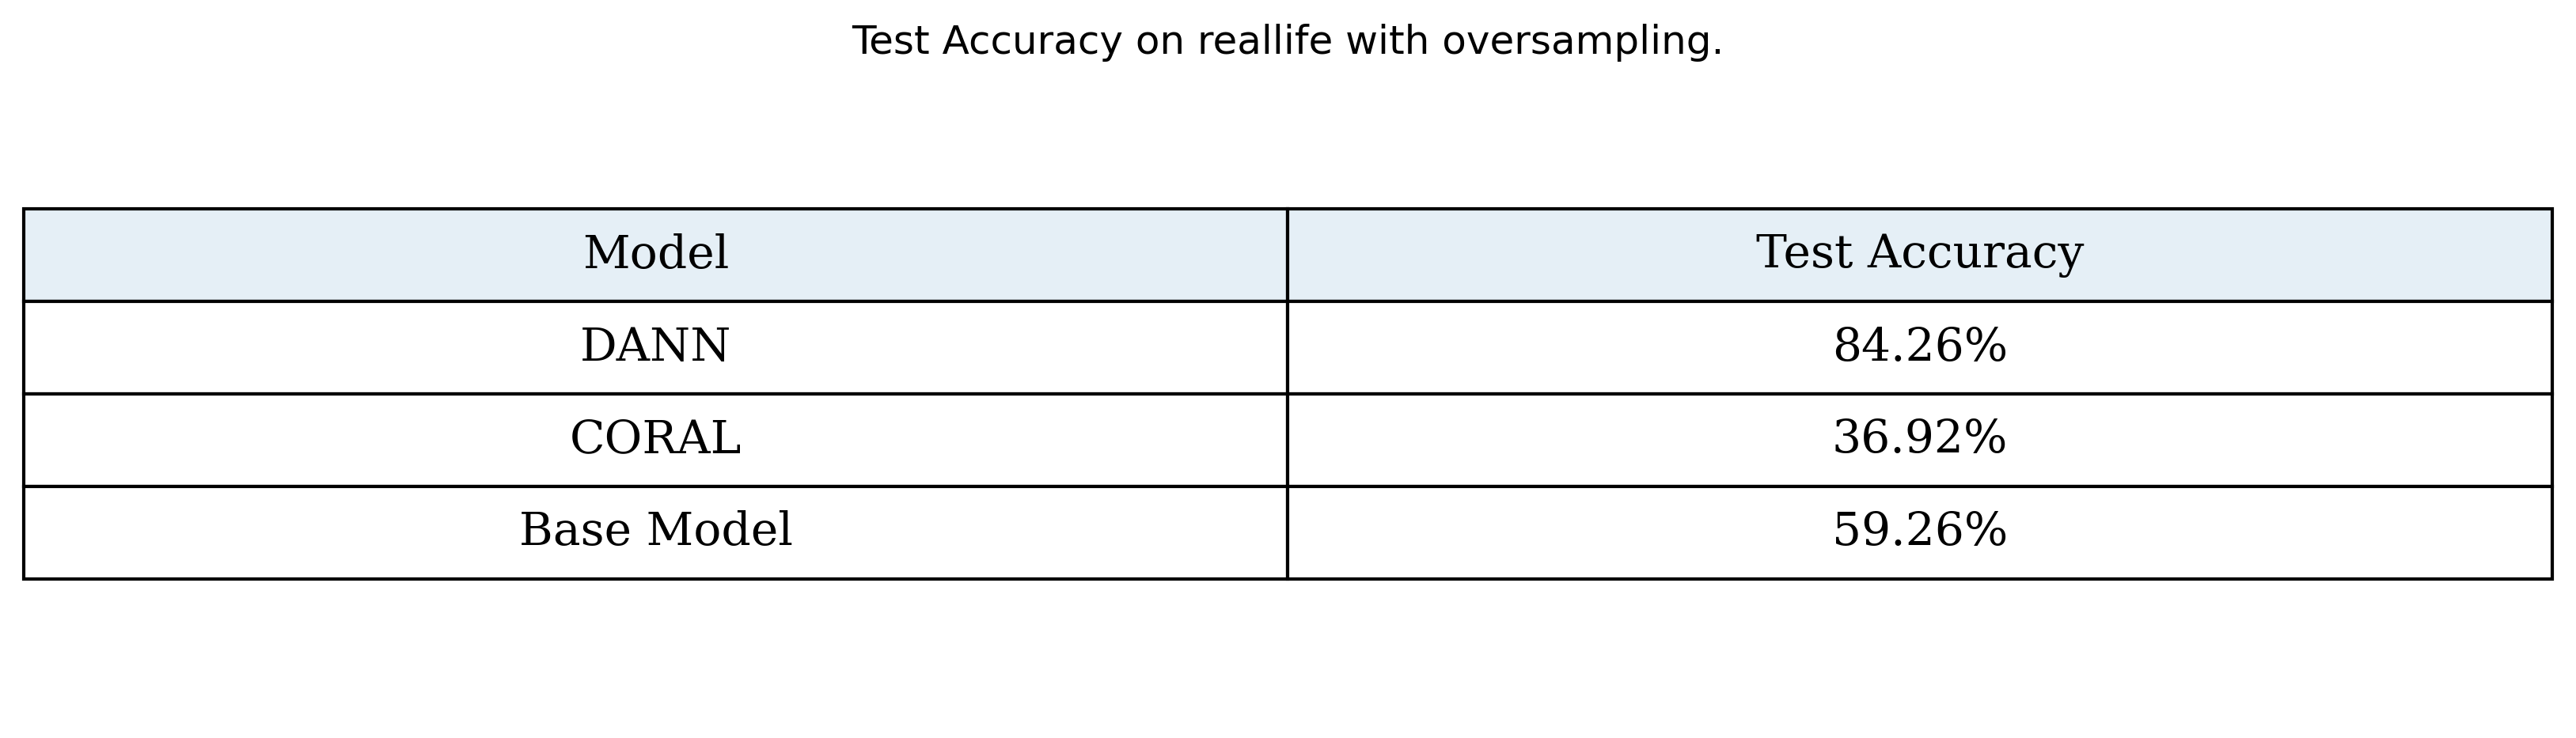

In [ ]:
tabulate_results(accuracies_real_life_oversample, "real life", True, "-acc")

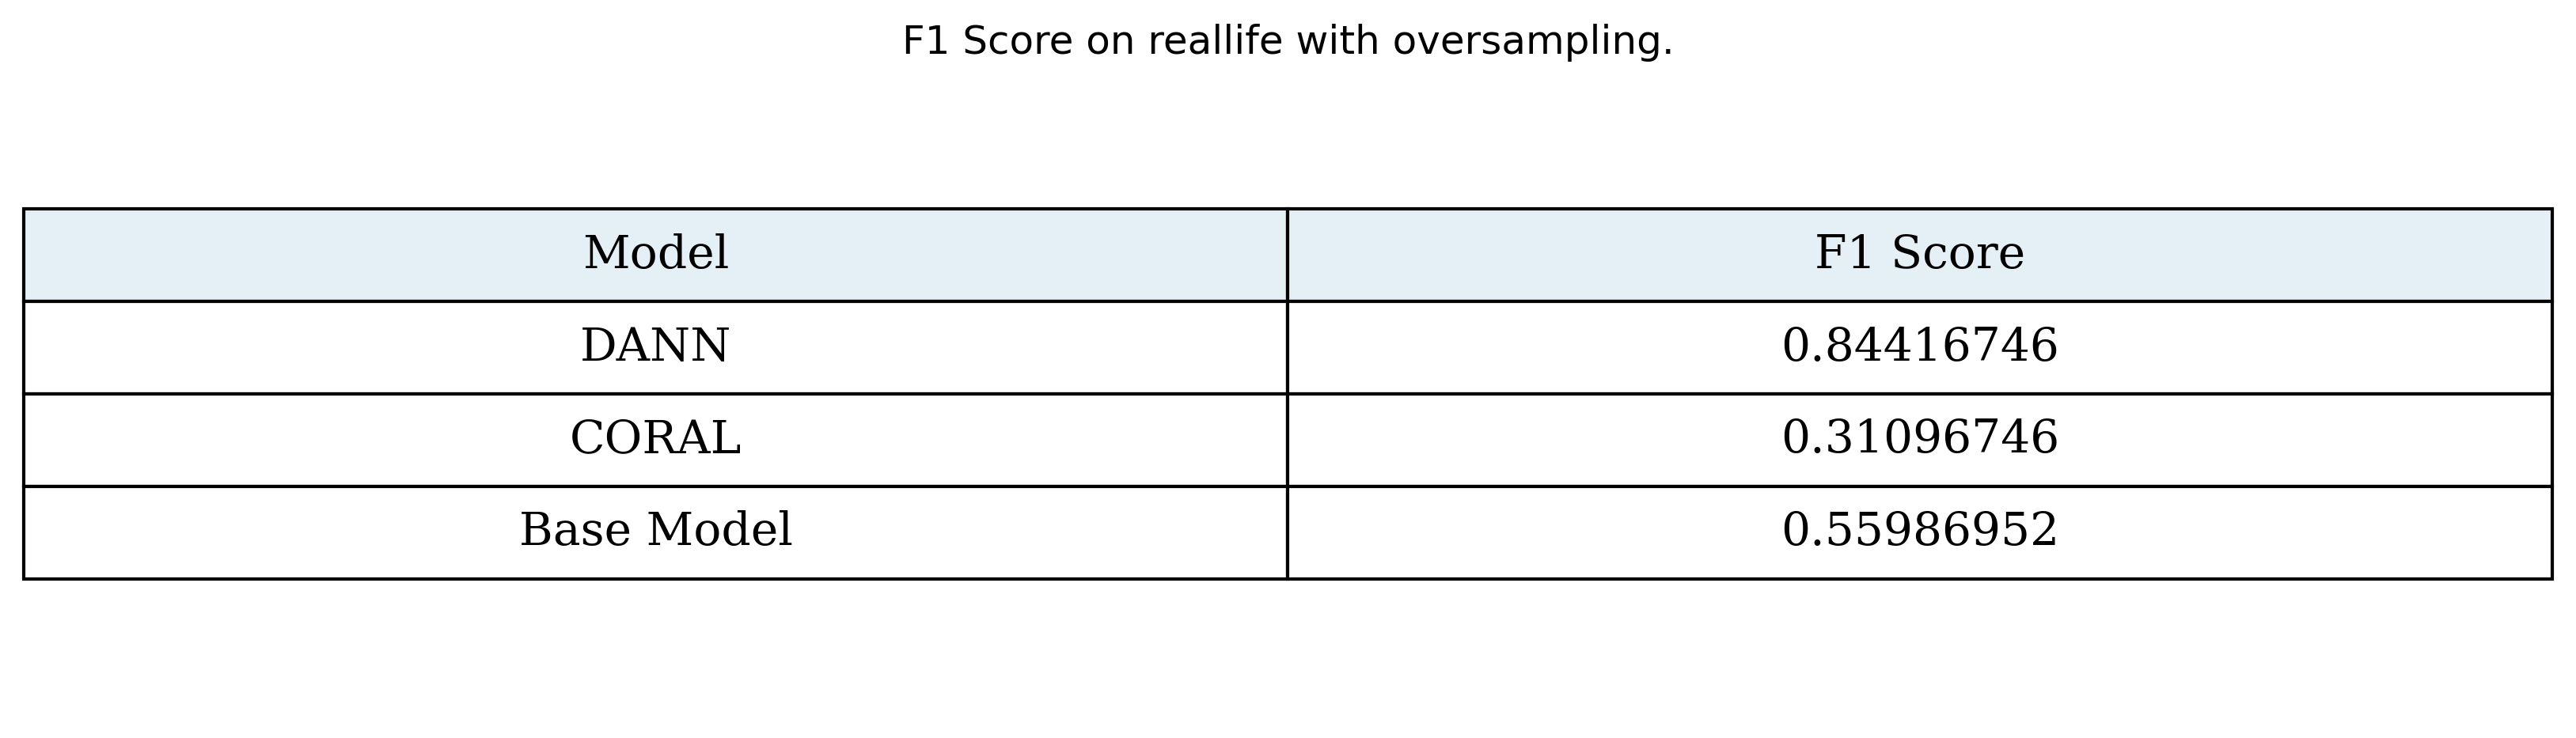

In [ ]:
tabulate_results(accuracies_real_life_no_oversample, "real life", False, "-acc")

In [ ]:
tabulate_results(accuracies_generated_oversample, "generated", True, "-acc")

In [ ]:
tabulate_results(accuracies_generated_no_oversample, "generated", False, "-acc")

### F1-Score

In [ ]:
tabulate_results(f1s_real_life_oversample, "real life", True, "-f1")

In [ ]:
tabulate_results(f1s_real_life_no_oversample, "real life", False, "-f1")

In [ ]:
tabulate_results(f1s_generated_oversample, "generated", True, "-f1")

In [ ]:
tabulate_results(f1s_generated_no_oversample, "generated", False, "-f1")

### Confusion Matrix

#### Real Life Dataset with oversample

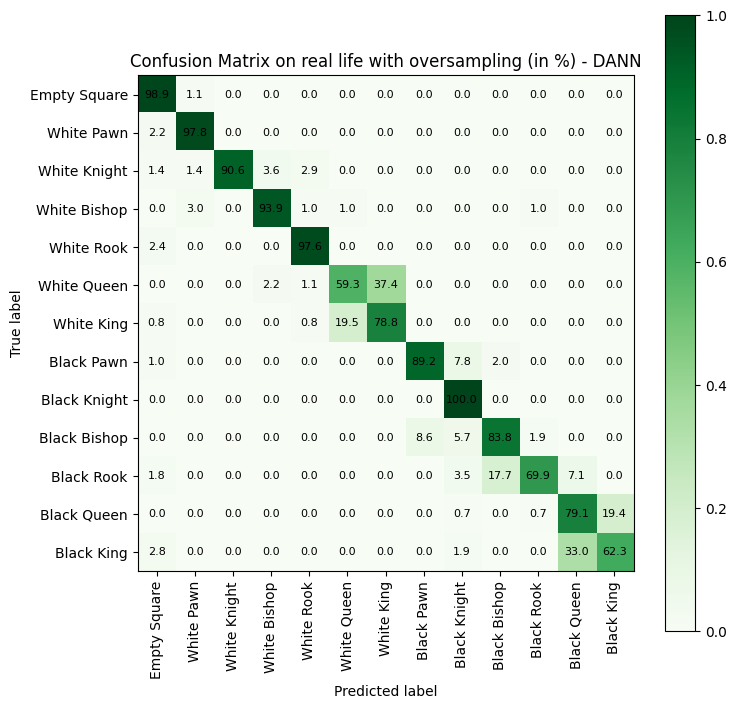

In [ ]:
plot_confusion_matrix(confusion_matrices_real_life_oversample[0], "DANN", "real life", True)

In [ ]:
plot_confusion_matrix(confusion_matrices_real_life_oversample[1], "CORAL", "real life", True)

In [ ]:
plot_confusion_matrix(confusion_matrices_real_life_oversample[2], "Base", "real life", True)

#### Real Life Dataset without oversample

In [ ]:
plot_confusion_matrix(confusion_matrices_real_life_no_oversample[0], "DANN", "real life", False)

In [ ]:
plot_confusion_matrix(confusion_matrices_real_life_no_oversample[1], "CORAL", "real life", False)

In [ ]:
plot_confusion_matrix(confusion_matrices_real_life_no_oversample[2], "Base", "real life", False)

#### Generated Dataset with oversample

In [ ]:
plot_confusion_matrix(confusion_matrices_generated_oversample[0], "DANN", "generated", True)

In [ ]:
plot_confusion_matrix(confusion_matrices_generated_oversample[1], "CORAL", "generated", True)

In [ ]:
plot_confusion_matrix(confusion_matrices_generated_oversample[2], "Base", "generated", True)

#### Generated Dataset without oversample

In [ ]:
plot_confusion_matrix(confusion_matrices_generated_no_oversample[0], "DANN", "generated", False)

In [ ]:
plot_confusion_matrix(confusion_matrices_generated_no_oversample[1], "CORAL", "generated", False)

In [ ]:
plot_confusion_matrix(confusion_matrices_generated_no_oversample[2], "Base", "generated", False)

### Average AUPRCs

In [ ]:
tabulate_results(auprcs_real_life_oversample, "real life", True, "-auprc")

In [ ]:
tabulate_results(auprcs_real_life_no_oversample, "real life", False, "-auprc")

In [ ]:
tabulate_results(auprcs_generated_oversample, "generated", True, "-auprc")

In [ ]:
tabulate_results(auprcs_generated_no_oversample, "generated", False, "-auprc")